# Ex4 어제 오른 내 주식, 과연 내일은?
---
---
**루브릭 평가모델** 
1. 시계열의 안정성이 충분히 확인되었는가? - 플로팅과 adfuller 메소드 사용으로 시계열의 안정성이 (충분히) 확인되는 것을 시각화하였으며, 이에 대한 충분한 설명(해당 메소드에 대한 이해)이 서술되어있음

2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가? - p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨
3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가? - 3개 이상 종목이 **MAPE 15% 미만**의 정확도로 예측됨

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
import os

from os.path import join
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = '/content/drive/MyDrive/EX4/'

In [ ]:
hyundai_data_path = join(data_dir, 'hyundai.csv')
kakao_data_path = join(data_dir, 'kakao.csv')
tyt_data_path = join(data_dir, 'TM.csv')
ab_data_path = join(data_dir, 'blizzard.csv')

In [ ]:
df1 = pd.read_csv(hyundai_data_path)
df2 = pd.read_csv(kakao_data_path)
df3 = pd.read_csv(tyt_data_path)
df4 = pd.read_csv(ab_data_path)
df1.head() # Hyundai Motors

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-09-28,204000.0,204000.0,200500.0,201500.0,196670.562500,719631
1,2021-09-29,197500.0,202000.0,197500.0,201500.0,196670.562500,934463
2,2021-09-30,200000.0,201000.0,199000.0,200000.0,195206.515625,594666
3,2021-10-01,198000.0,199000.0,192000.0,193500.0,188862.296875,1182422
4,2021-10-05,191000.0,195000.0,189000.0,193500.0,188862.296875,1056472


In [ ]:
df2.head() # Kakao

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-09-28,121386.117188,122393.468750,118364.054688,118364.054688,118309.187500,3420430
1,2021-09-29,115845.671875,118364.054688,115342.000000,117356.703125,117302.304688,3149191
2,2021-09-30,115845.671875,121386.117188,115342.000000,118867.734375,118812.632813,4615972
3,2021-10-01,118867.734375,120882.445313,116853.023438,117356.703125,117302.304688,2312100
4,2021-10-05,115342.000000,116853.023438,111312.578125,111816.257813,111764.429688,4849404


In [ ]:
df3.head() # Toyota

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-09-27,185.080002,186.860001,185.009995,186.520004,186.520004,221600
1,2021-09-28,186.089996,186.399994,184.149994,184.850006,184.850006,197600
2,2021-09-29,185.130005,187.449997,183.779999,185.449997,185.449997,238600
3,2021-09-30,180.679993,181.539993,177.750000,177.750000,177.750000,403400
4,2021-10-01,178.110001,178.259995,176.419998,177.619995,177.619995,241800


In [ ]:
df4.head() # Activision Blizzard

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-09-27,75.029999,75.949997,73.690002,75.080002,74.636360,6517900
1,2021-09-28,74.660004,77.080002,74.660004,76.330002,75.878967,11157200
2,2021-09-29,76.529999,78.930000,76.500000,77.379997,76.922760,9700800
3,2021-09-30,77.559998,78.410004,77.000000,77.389999,76.932701,7537900
4,2021-10-01,78.059998,79.040001,77.199997,78.529999,78.065971,5861300


* 9월 27일 미국장 기준으로 현대자동차, 카카오, 토요타, 블리자드를 분석 모델로 선정하였다.

# 현대자동차

1. 각종 전처리 수행

In [ ]:
#Time Series(시계열 데이터) 생성
df1 = pd.read_csv(hyundai_data_path, index_col='Date', parse_dates=True)
ts = df1['Close']

ts.head() #현대자동차 시계열

Date
2021-09-28    201500.0
2021-09-29    201500.0
2021-09-30    200000.0
2021-10-01    193500.0
2021-10-05    193500.0
Name: Close, dtype: float64

In [ ]:
ts = ts.interpolate(method='time')
ts[ts.isna()]  #Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [ ]:
ts_log = np.log(ts) #현대자동차 시계열 로그변환

2. 시계열 안정성 분석

In [ ]:
def augmented_dickey_fuller_test(timeseries):
    #statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')
    
    #adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [ ]:
#일정 시간 내 구간 통계치(Rolling Statistics) 시각화하는 함수
def plot_rolling_statistics(timeseries, window=12):
    rolmean = timeseries.rolling(window=window).mean()  #이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    #이동표준편차 시계열

     #원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='orange', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

# Augmented Dickey-Fuller Test
---- 

*  시계열 데이터가 안정적(stationary)인지 확인하기 위한 통계적 테스트이다.
*  주어진 시계열 데이터가 안정적이지 않다라는 귀무가설(Null Hypothesis)를 세운다.
*  통계적 가설 검정 과정을 통해 이 귀무가설이 기각될 경우에 이 시계열 데이터가 안정적이다라는 대립가설(Alternative Hypothesis)을 채택한다


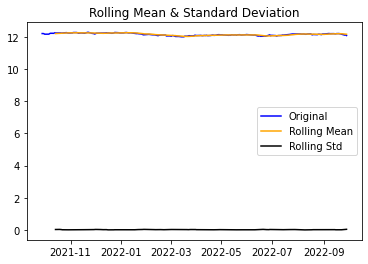

Results of Dickey-Fuller Test:
Test Statistic                  -1.784973
p-value                          0.387947
#Lags Used                       0.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


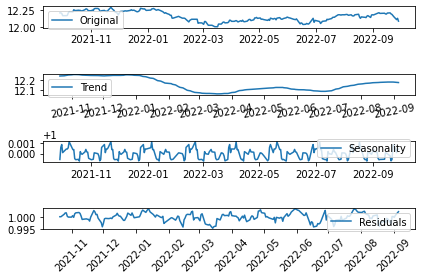

In [ ]:
#정성적 그래프 분석
plot_rolling_statistics(ts_log, window=11)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) #30일 주기
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) #30일 주기

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.xticks(rotation = 10)
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.xticks(rotation = 45)
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
#Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.784973
p-value                          0.387947
#Lags Used                       0.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


3. 학습, 테스트 데이터셋 생성

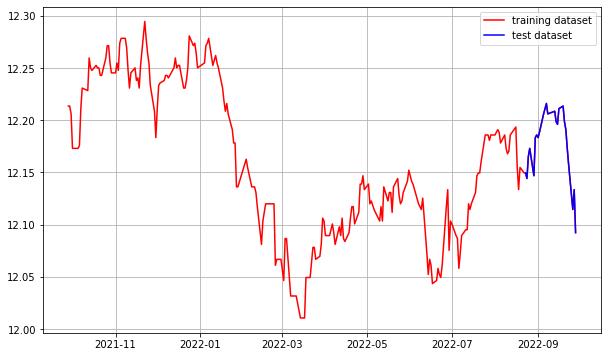

In [ ]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

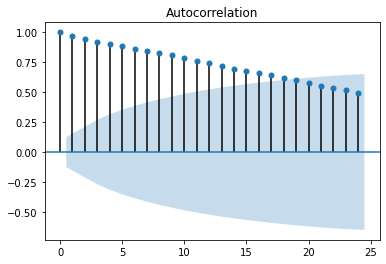

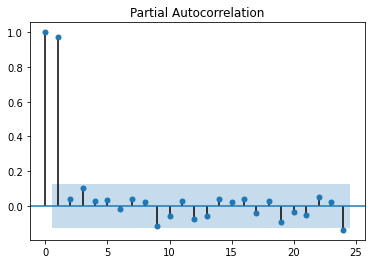

In [ ]:
#ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   #ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  #PACF : Partial Autocorrelation 그래프 그리기
plt.show()

In [ ]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(5, 0, 18)) #모수는 이전 그래프를 참고(ACF로 q값 18을 확인, AR은 5가 절단점)
fitted_m = model.fit()

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  221
Model:                ARIMA(8, 0, 18)   Log Likelihood                 602.332
Date:                Thu, 29 Sep 2022   AIC                          -1148.664
Time:                        08:35:47   BIC                          -1053.515
Sample:                             0   HQIC                         -1110.244
                                - 221                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.1664      0.047    258.722      0.000      12.074      12.259
ar.L1          0.5690      3.677      0.155      0.877      -6.638       7.776
ar.L2          0.1999      2.106      0.095      0.9

Results of Dickey-Fuller Test:
Test Statistic                -1.241109e+01
p-value                        4.341984e-23
#Lags Used                     1.000000e+00
Number of Observations Used    2.430000e+02
Critical Value (1%)           -3.457551e+00
Critical Value (5%)           -2.873509e+00
Critical Value (10%)          -2.573148e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.241109e+01
p-value                        4.341984e-23
#Lags Used                     1.000000e+00
Number of Observations Used    2.430000e+02
Critical Value (1%)           -3.457551e+00
Critical Value (5%)           -2.873509e+00
Critical Value (10%)          -2.573148e+00
dtype: float64


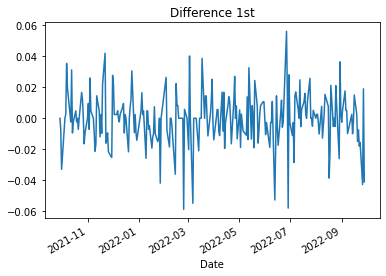

In [ ]:
#차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

#2차 차분 구하기

augmented_dickey_fuller_test(diff_1)

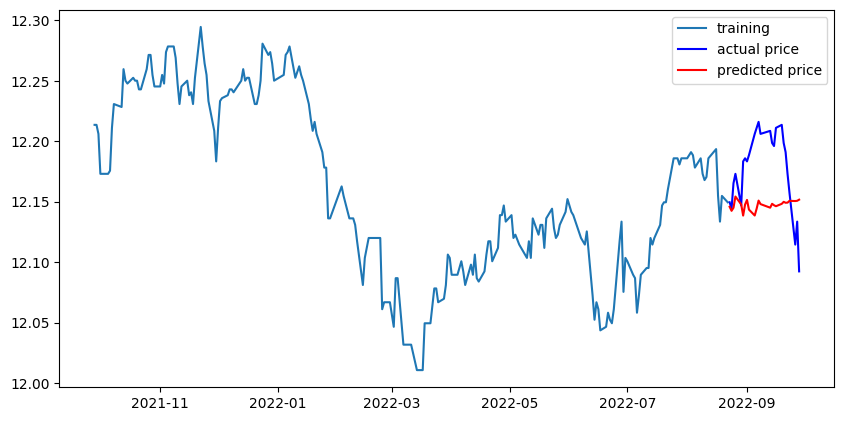

In [ ]:
#Forecast : 결과가 fc에 담깁니다.
fc = fitted_m.forecast(len(test_data), alpha=0.05)  #95% conf
fc = np.array(fc)
#Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   #예측결과

#Plot0
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  76241334.80891095
MAE:  7620.173062429935
RMSE:  8731.628416790934
MAPE: 3.88%




*  MAPE 값이 3.88%

#카카오

In [ ]:
df2 = pd.read_csv(kakao_data_path, index_col='Date', parse_dates=True)
ts1 = df2['Close']

ts1.head() # 카카오 시계열

Date
2021-09-28    118364.054688
2021-09-29    117356.703125
2021-09-30    118867.734375
2021-10-01    117356.703125
2021-10-05    111816.257813
Name: Close, dtype: float64

In [ ]:
ts1 = ts1.interpolate(method='time')
ts1[ts1.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [ ]:
ts1_log = np.log(ts1) # 카카오 로그변환

In [ ]:
def augmented_dickey_fuller_test(timeseries):
    #statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')
    
    #adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [ ]:
#일정 시간 내 구간 통계치(Rolling Statistics) 시각화하는 함수
def plot_rolling_statistics(timeseries, window=12):
    rolmean = timeseries.rolling(window=window).mean()  #이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    #이동표준편차 시계열

     #원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='orange', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

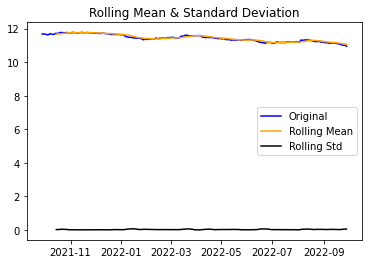

Results of Dickey-Fuller Test:
Test Statistic                   0.183315
p-value                          0.971310
#Lags Used                       3.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64


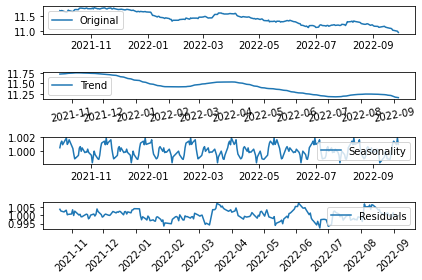

In [ ]:
#정성적 그래프 분석
plot_rolling_statistics(ts1_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts1_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts1_log, model='multiplicative', period = 30) #30일 주기
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts1_log, model='multiplicative', period = 30) #30일 주기

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts1_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.xticks(rotation = 10)
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.xticks(rotation = 45)
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
#Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(ts1_log)

Results of Dickey-Fuller Test:
Test Statistic                   0.183315
p-value                          0.971310
#Lags Used                       3.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64


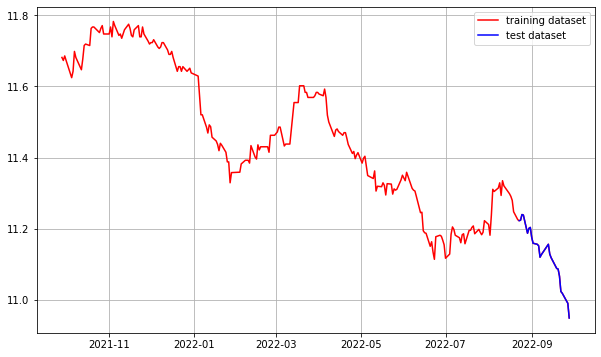

In [ ]:
train_data, test_data = ts1_log[:int(len(ts1_log)*0.9)], ts1_log[int(len(ts1_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts1_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

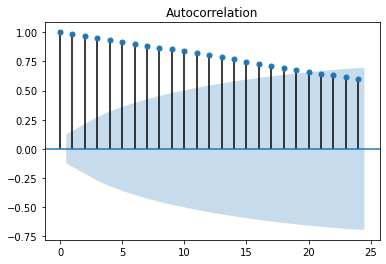

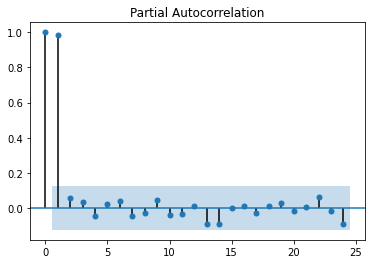

In [ ]:
#ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts1_log)   #ACF : Autocorrelation 그래프 그리기
plot_pacf(ts1_log)  #PACF : Partial Autocorrelation 그래프 그리기
plt.show()

In [ ]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(3, 0, 19)) #모수(AR상에서 절단점 p = 3, ACF기준 q값이 19)
fitted_m = model.fit()

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  221
Model:                ARIMA(3, 0, 19)   Log Likelihood                 516.303
Date:                Thu, 29 Sep 2022   AIC                           -984.607
Time:                        08:50:31   BIC                           -903.051
Sample:                             0   HQIC                          -951.676
                                - 221                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.4591      0.114    100.817      0.000      11.236      11.682
ar.L1          1.0672     17.056      0.063      0.950     -32.362      34.496
ar.L2          0.0331     23.869      0.001      0.9

Results of Dickey-Fuller Test:
Test Statistic                -7.908458e+00
p-value                        4.007365e-12
#Lags Used                     2.000000e+00
Number of Observations Used    2.420000e+02
Critical Value (1%)           -3.457664e+00
Critical Value (5%)           -2.873559e+00
Critical Value (10%)          -2.573175e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.908458e+00
p-value                        4.007365e-12
#Lags Used                     2.000000e+00
Number of Observations Used    2.420000e+02
Critical Value (1%)           -3.457664e+00
Critical Value (5%)           -2.873559e+00
Critical Value (10%)          -2.573175e+00
dtype: float64


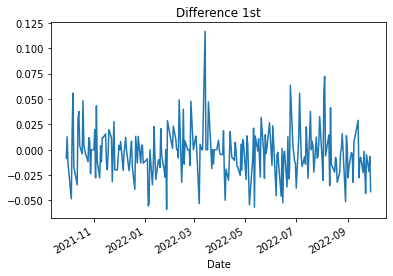

In [ ]:
#차분 안정성 확인 -> d 구하기
diff_1 = ts1_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

#2차 차분 구하기

augmented_dickey_fuller_test(diff_1)

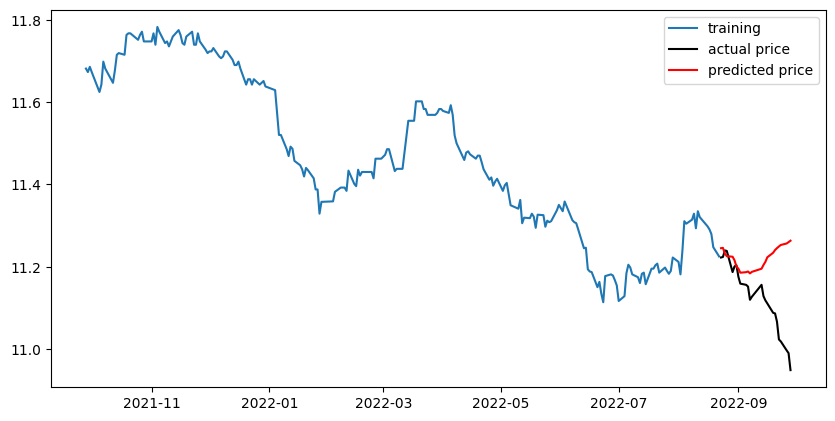

In [ ]:
#Forecast : 결과가 fc에 담깁니다.
fc = fitted_m.forecast(len(test_data), alpha=0.05)  #95% conf
fc = np.array(fc)
#Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   #예측결과

#Plot0
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='k', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  87479166.60176685
MAE:  6833.50567504359
RMSE:  9353.029808664509
MAPE: 10.85%


*  MAPE 값이 10.85%

#토요타

In [ ]:
df3 = pd.read_csv(tyt_data_path, index_col='Date', parse_dates=True)
ts2 = df3['Close']

ts2.head() # 토요타 시계열

Date
2021-09-27    186.520004
2021-09-28    184.850006
2021-09-29    185.449997
2021-09-30    177.750000
2021-10-01    177.619995
Name: Close, dtype: float64

In [ ]:
ts2 = ts2.interpolate(method='time')
ts2[ts2.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [ ]:
ts2_log = np.log(ts2) # 토요타 로그변환

In [ ]:
def augmented_dickey_fuller_test(timeseries):
    #statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')
    
    #adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [ ]:
#일정 시간 내 구간 통계치(Rolling Statistics) 시각화하는 함수
def plot_rolling_statistics(timeseries, window=12):
    rolmean = timeseries.rolling(window=window).mean()  #이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    #이동표준편차 시계열

     #원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='orange', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

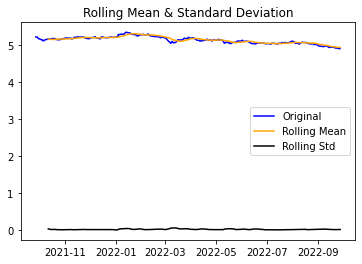

Results of Dickey-Fuller Test:
Test Statistic                  -0.600666
p-value                          0.870831
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


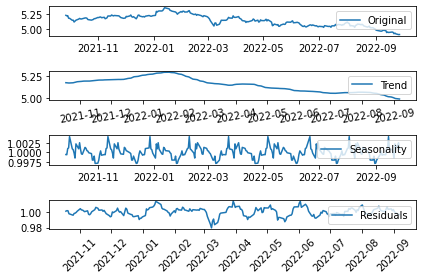

In [ ]:
#정성적 그래프 분석
plot_rolling_statistics(ts2_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts2_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts2_log, model='multiplicative', period = 30) #30일 주기
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts2_log, model='multiplicative', period = 30) #30일 주기

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts2_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.xticks(rotation = 10)
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.xticks(rotation = 45)
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
#Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(ts2_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.600666
p-value                          0.870831
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


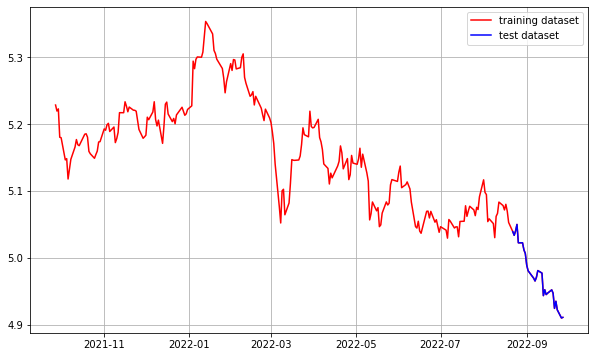

In [ ]:
train_data, test_data = ts2_log[:int(len(ts2_log)*0.9)], ts2_log[int(len(ts2_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts2_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts2_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

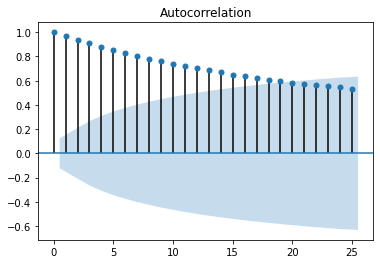

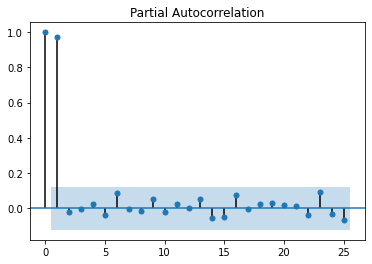

In [ ]:
#ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts2_log)   #ACF : Autocorrelation 그래프 그리기
plot_pacf(ts2_log)  #PACF : Partial Autocorrelation 그래프 그리기
plt.show()

In [ ]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 0, 19)) #모수(AR가)
fitted_m = model.fit()

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                ARIMA(1, 0, 19)   Log Likelihood                 598.101
Date:                Thu, 29 Sep 2022   AIC                          -1152.202
Time:                        08:51:34   BIC                          -1076.853
Sample:                             0   HQIC                         -1121.798
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1485      0.056     92.395      0.000       5.039       5.258
ar.L1          0.9866      0.019     51.903      0.000       0.949       1.024
ma.L1          0.0430      0.077      0.555      0.5

Results of Dickey-Fuller Test:
Test Statistic                -1.571267e+01
p-value                        1.353526e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.571267e+01
p-value                        1.353526e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64


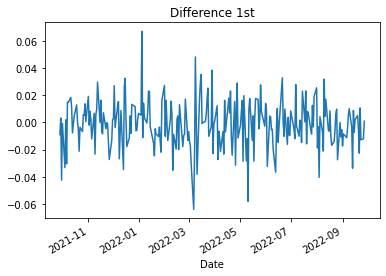

In [ ]:
#차분 안정성 확인 -> d 구하기
diff_1 = ts2_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

#2차 차분 구하기

augmented_dickey_fuller_test(diff_1)

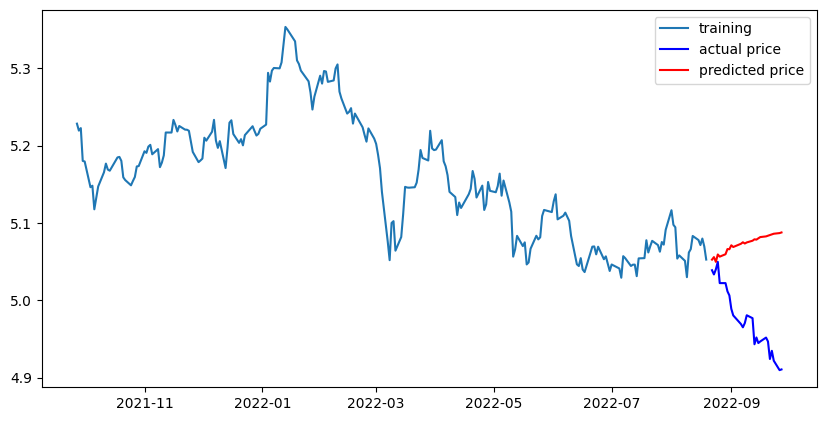

In [ ]:
#Forecast : 결과가 fc에 담깁니다.
fc = fitted_m.forecast(len(test_data), alpha=0.05)  #95% conf
fc = np.array(fc)
#Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   #예측결과

#Plot0
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  279.8850334105017
MAE:  14.814196168002171
RMSE:  16.729764894059382
MAPE: 10.47%


*  MAPE 값이 10.47%

#블리자드

In [ ]:
df4 = pd.read_csv(ab_data_path, index_col='Date', parse_dates=True)
ts3 = df4['Close']

ts3.head() # 블리자드 시계열

Date
2021-09-27    75.080002
2021-09-28    76.330002
2021-09-29    77.379997
2021-09-30    77.389999
2021-10-01    78.529999
Name: Close, dtype: float64

In [ ]:
ts3 = ts3.interpolate(method='time')
ts3[ts3.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [ ]:
ts3_log = np.log(ts3) # 액티비전 블리자드 로그변환

In [ ]:
def augmented_dickey_fuller_test(timeseries):
    #statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')
    
    #adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [ ]:
#일정 시간 내 구간 통계치(Rolling Statistics) 시각화하는 함수
def plot_rolling_statistics(timeseries, window=12):
    rolmean = timeseries.rolling(window=window).mean()  #이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    #이동표준편차 시계열

     #원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='orange', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

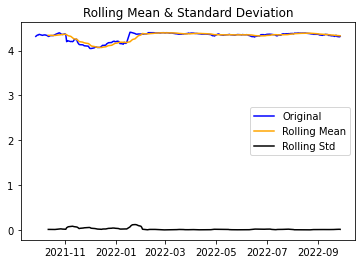

Results of Dickey-Fuller Test:
Test Statistic                  -1.782687
p-value                          0.389090
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


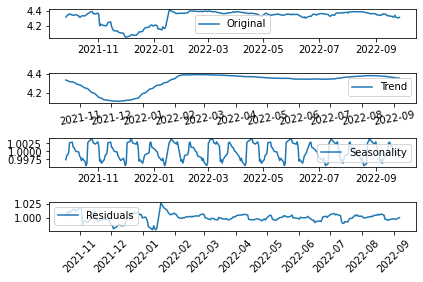

In [ ]:
#정성적 그래프 분석
plot_rolling_statistics(ts3_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts3_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts3_log, model='multiplicative', period = 30) #30일 주기
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts3_log, model='multiplicative', period = 30) #30일 주기

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts3_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.xticks(rotation = 10)
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.xticks(rotation = 45)
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
#Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(ts3_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.782687
p-value                          0.389090
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


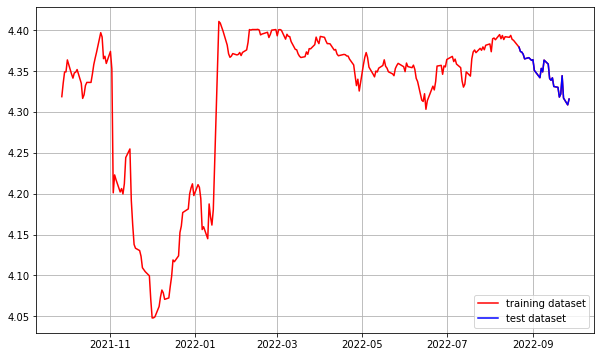

In [ ]:
train_data, test_data = ts3_log[:int(len(ts3_log)*0.9)], ts3_log[int(len(ts3_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts3_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

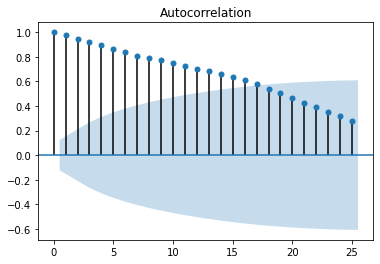

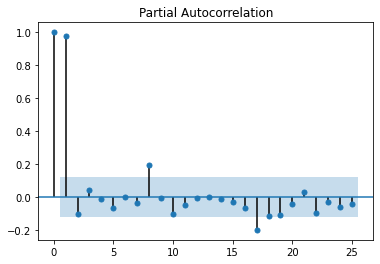

In [ ]:
#ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts3_log)   #ACF : Autocorrelation 그래프 그리기
plot_pacf(ts3_log)  #PACF : Partial Autocorrelation 그래프 그리기
plt.show()

In [ ]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 0, 16)) #모수는(AR p = 1, ACF q = 16)
fitted_m = model.fit()

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                ARIMA(1, 0, 16)   Log Likelihood                 557.409
Date:                Thu, 29 Sep 2022   AIC                          -1076.818
Time:                        08:48:43   BIC                          -1011.744
Sample:                             0   HQIC                         -1050.559
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3232      0.102     42.545      0.000       4.124       4.522
ar.L1          0.9661      0.038     25.148      0.000       0.891       1.041
ma.L1          0.0625      0.092      0.676      0.4

Results of Dickey-Fuller Test:
Test Statistic                -1.470668e+01
p-value                        2.890077e-27
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.470668e+01
p-value                        2.890077e-27
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64


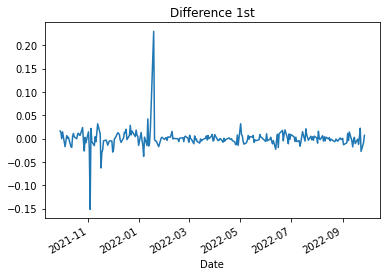

In [ ]:
#차분 안정성 확인 -> d 구하기
diff_1 = ts3_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

#2차 차분 구하기

augmented_dickey_fuller_test(diff_1)

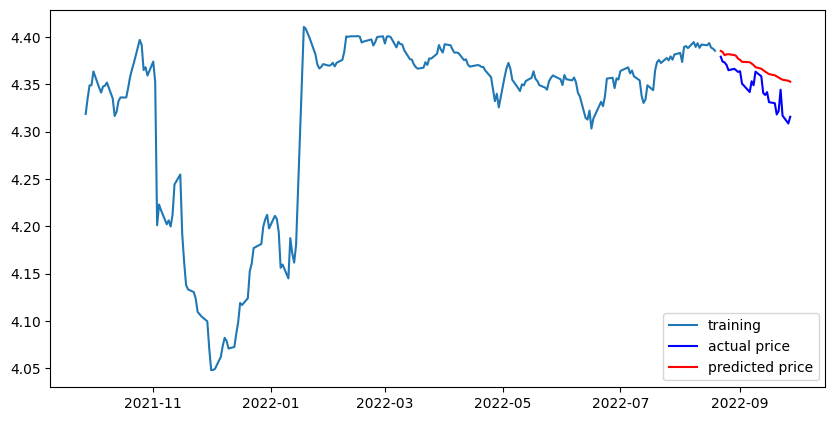

In [ ]:
#Forecast : 결과가 fc에 담깁니다.
fc = fitted_m.forecast(len(test_data), alpha=0.05)  #95% conf
fc = np.array(fc)
#Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   #예측결과

#Plot0
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3.434621339195365
MAE:  1.642791080187669
RMSE:  1.8532731420908697
MAPE: 2.15%


*  MAPE 값이 2.15%

---

*  주식 종목 예측 비교
*  현대자돋차 MAPE - 3.91% 
*  카카오 MAPE - 10.38%
*  토요타 8.07% MAPE 도출
*  블리자드 3.91% MAPE 도출

-Mape란 예측값과 실제값을 뺀 값을 실제값으로 나누고 이를 퍼센테이지로 나타내어, 예측모델과 실제 모델의 오차범위를 나타낸 수치이다. 퍼센테이지가 낮을수록 정확도가 좋다는 뜻이 된다.

-이번 분석에서 모든 종목이 루브릭의 기준인 15% 이하로 측정이 되었다.

-현대자동차와 블리자드의 예측 결과가 같은 값으로 나왔다. 두 회사의 주가를 보면 전혀 다른 양상으로 흘러가는 것이 보이지만 MAPE 값이 동일 한 것을 보면 둘다 나름대로 정확하게 예측을 했다고 모델이 판단하는 것 같다.

-하지만, 이를 토대로 실제로 투자를 한다? 이건 말도 안된다고 생각. 오차율이 3.91%로 수치상 놓은 것으로 나왔지만, 실제 결과값과 전혀 다른 양상으로 흘러 가기 때문에 썩 좋지가 않았다.(아무래도 3개월 데이터로는 더 정확한 학습이 어렵지 않을가 싶다.)

-ARIMA 모델을 빌드하고 훈련 할 때 model = ARIMA(train_data, order=(2, 0, 1)) 로 처음 설정되어있었고, p,d,q를 2,0,1 그대로 수행하니 오류가 나며 MAPE가 낮은 정확도로 예측되어 모수에 대해 조사했다. 위 부분을 해결하기 위해서는 그리드 서치를 통해 AIC수치가 가장 낮은 값으로 설정하여 모수를 선택해야한다는 것을 알 수 있었다. 모수 도출 함수는 my_auto_arima(lu_train, [p,d,q])를 사용하여 가장 낮은 값을 모수로 선정했다.

모수 설정에 따라 MAPE 정확도가 달라져 가장 최적의 모수를 찾아 예측 모델을 만들어 정확도를 측정하였다. 정확도가 15% 이상이 나와 모수 변경에 따라 값이 줄어들어 모수에 대한 개념과 ARIMA에 대한 이론적 개념이 많이 필요했다. 아직 개념정립이 부족해 다음에 또 시계열 프로젝트를 수행한다고 해도 수월하게 할 수 있을지는 모르겠다. 개인적으로 통계적 지식이 매우 부족함을 느껴서 이론적 정립이 필요하다 느꼈다. 그래도 시계열 데이터를 가지고 주가 예측을 하는 프로젝트는 흥미로웠고, 평소 내가 관심있는 주식 종목들을 분석해보는 경험이 새로웠다. 조금 더 오차율을 줄인다면 실제로 실생활에 활용하고 싶다